In [1]:
from lib.abstract_torch import get_device, get_loss, get_optimizer
from lib.dataloader import get_MNIST_loaders
from lib.models import ANN, LoRA_ANN
from lib.train import train_ANN
from lib.test import test
from lib.save import save

import os
import numpy as np
import torch

In [2]:
train_vanilla = False

In [3]:
device = get_device()

In [24]:
path = os.path.dirname(os.path.abspath("__file__"))
data_path = path + "\\data"
model_path = path + "\\ANN_LoRA\\"

Playable HPs :
- LoRA rank
- trade-off

Other HPs :
- batch_size

In [27]:
# Data parameter
batch_size=128

# Network Architecture
num_inputs = 28*28
num_hidden = 100
num_outputs = 10

# Train parameters
loss_name = "CE"
optimizer_name = "Adam"

## Reproducibility

In [6]:
np.random.seed(42)
torch.manual_seed(42)

if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Ensure deterministic behavior in PyTorch
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Get MNIST loaders

In [7]:
# We train on MNIST 0 to 4, then each new task is being able to classify a new digit (5 to 9)

In [8]:
task_name_1_to_5 = "task_"+str(1)+"_to_"+str(5)
train_loader_1_to_5, val_loader_1_to_5, test_loader_1_to_5 = get_MNIST_loaders(data_path, [0,1,2,3,4], batch_size)

task_names = []
train_loaders, val_loaders, test_loaders = [], [], []

for i in range(10) :
    task_names.append("task_"+str(i+1))
    class_label = [i]
    train_loader, val_loader, test_loader = get_MNIST_loaders(data_path, class_label, batch_size)
    train_loaders.append(train_loader)
    val_loaders.append(val_loader)
    test_loaders.append(test_loader)

## Train vanilla ANN on digits 0 to 4

In [9]:
if train_vanilla :
    train_loader = train_loader_1_to_5

In [10]:
if train_vanilla :
    lr = 1e-3
    num_epochs = 2

In [11]:
if train_vanilla :
    model = ANN(num_inputs, num_hidden, num_outputs)

In [12]:
if train_vanilla :
    train_ANN(model, loss_name, optimizer_name, lr, train_loader, num_epochs, batch_size, device)

In [13]:
if train_vanilla :
    test(model, test_loader_1_to_5, batch_size, device)

## Save vanilla ANN

In [14]:
if train_vanilla :
    vanilla_path = model_path+"ICL5_state_dict_digits_0_to_4.pth"

In [15]:
if train_vanilla :
    save(vanilla_path, model)

## CL on digits 5 to 9 with LoRA

In [16]:
import optuna
from functools import partial
import matplotlib.pyplot as plt

In [17]:
def define_model(trial, model_path, params) :
    lora_rank = trial.suggest_int("lora_rank", 8, 16)
    alpha = trial.suggest_float("alpha", 0.5, 2)
    
    num_inputs, num_hidden, num_outputs, batch_size = params
    lora_ann_model = LoRA_ANN(lora_rank,
                              alpha, 
                              model_path, 
                              num_inputs, 
                              num_hidden, 
                              num_outputs,
                              batch_size)

    return lora_ann_model

def objective(task_number, model_path, params, device, trial) :
    # Define model
    lora_ann_model = define_model(trial, model_path, params).to(device)
    
    # Set HPs
    lr = trial.suggest_float("lr", 1e-5, 5e-4)
    num_epochs = trial.suggest_int("num_epochs", 1, 4)
    
    # Train
    batch_size = params[-1]
    
    task = task_names[task_number]
    train_loader = train_loaders[task_number]
    #val_loader = val_loaders[task_number]

    train_ANN(lora_ann_model, loss_name, optimizer_name, lr, train_loader, num_epochs, batch_size, device)
    
    # Test
    test_accs = np.zeros(task_number+1)
    for j in range(task_number+1) :
        test_acc = test(lora_ann_model, test_loaders[j], batch_size, device)
        test_accs[j] = test_acc
    
    # Compute score
    mu, sigma = np.mean(test_accs), np.std(test_accs)
    score = mu - sigma
    
    return score

In [29]:
def retrain_and_save_with_best_HPs (best_trial, i, model_path) :
    lora_rank  = best_trial.params["lora_rank"]
    alpha = best_trial.params["alpha"]
    lr = best_trial.params["lr"]
    num_epochs = best_trial.params["num_epochs"]
    
    lora_ann_model = LoRA_ANN(lora_rank,
                              alpha, 
                              model_path, 
                              num_inputs, 
                              num_hidden, 
                              num_outputs,
                              batch_size).to(device)

    # Train
    
    task = task_names[i]
    train_loader = train_loaders[i]
    val_loader = val_loaders[i]

    train_ANN(lora_ann_model, loss_name, optimizer_name, lr, train_loader, num_epochs, batch_size, device)
    
    # Test
    test_accs = np.zeros(10)
    for j in range(10) :
        test_acc = test(lora_ann_model, test_loaders[j], batch_size, device)
        test_accs[j] = test_acc
    
    # Save model
    fc1_update = lora_ann_model.model.fc1.weight + alpha*torch.mm(lora_ann_model.l1_lora_A, lora_ann_model.l1_lora_B).T
    lora_ann_model.model.fc1.weight = torch.nn.Parameter(fc1_update)
    
    fc2_update = lora_ann_model.model.fc2.weight + alpha*torch.mm(lora_ann_model.l2_lora_A, lora_ann_model.l2_lora_B).T
    lora_ann_model.model.fc2.weight = torch.nn.Parameter(fc2_update)
    
    model_path = path + f"ICL5_state_dict_digit_{i}.pth"
    save(model_path, lora_ann_model.model)
    
    return test_accs

In [30]:
# Compute scores of the model trained on the first task
model_path = path + "\\ANN_LoRA\\ICL5_state_dict_digits_0_to_4.pth"

lora_rank = 16 # The value of this parameters has no influence
alpha = 1.8 # The value of this parameter has no influence

lora_ann_model = LoRA_ANN(lora_rank,
                          alpha, 
                          model_path, 
                          num_inputs, 
                          num_hidden, 
                          num_outputs, 
                          batch_size).to(device)

# Test the model trained on digits 0 to 4
test_accs = np.zeros(10)
for j in range(5) :
    test_acc = test(lora_ann_model, test_loaders[j], batch_size, device)
    test_accs[j] = test_acc
        
# Initialize variable to store the best HPs and the scores
best_params = []
scores = [test_acc]
test_accs_matrix = [test_accs]
mean_test_accs_through_past_tasks = [test_acc]

for i in range(5,10) :
    print(f"Learning Task {i+1}")
    # Perform HPO
    storage = optuna.storages.InMemoryStorage()
    study = optuna.create_study(storage=storage,
                                study_name="The Search",
                                #sampler=
                                direction = "maximize")
    
    params = num_inputs, num_hidden, num_outputs, batch_size
    partial_objective = partial(objective, i, model_path, params, device)
    study.optimize(partial_objective,
                   n_trials=3,
                   timeout=3600)

    # Retrain and save a model with the best params
    best_trial = study.best_trial
    best_params.append(best_trial.params)
    test_accs = retrain_and_save_with_best_HPs(best_trial, i, model_path) 
    
    model_path = path + f"ICL5_state_dict_digit_{i}.pth"
    
    # Compute and store scores
    mu, sigma = np.mean(test_accs[:i+1]), np.std(test_accs[:i+1])
    score = mu - sigma
    
    scores.append(score)
    test_accs_matrix.append(test_accs)
    mean_test_accs_through_past_tasks.append(mu)

[I 2024-05-24 10:36:20,418] A new study created in memory with name: The Search


Learning Task 6


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.56it/s]
[I 2024-05-24 10:36:22,520] Trial 0 finished with value: -19.596707629762793 and parameters: {'lora_rank': 16, 'alpha': 1.9353502622663663, 'lr': 0.0004925694621507596, 'num_epochs': 4}. Best is trial 0 with value: -19.596707629762793.
100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.65it/s]
[I 2024-05-24 10:36:24,553] Trial 1 finished with value: 25.670060899577315 and parameters: {'lora_rank': 13, 'alpha': 0.7545492437917638, 'lr': 0.0002595506758322009, 'num_epochs': 4}. Best is trial 1 with value: 25.670060899577315.
100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.63it/s]
[I 2024-05-24 10:36:25,466] Trial 2 finished with value: 48.439617023026415 and parameters: {'lora_rank': 16, 'alpha': 0.9330015595614313, 'lr': 0.0004750841809740517, 'n

Learning Task 7


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.26it/s]
[I 2024-05-24 10:36:27,827] Trial 0 finished with value: 24.4738207837146 and parameters: {'lora_rank': 9, 'alpha': 1.5218548989071987, 'lr': 0.00013582002117401953, 'num_epochs': 1}. Best is trial 0 with value: 24.4738207837146.
100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.20it/s]
[I 2024-05-24 10:36:29,370] Trial 1 finished with value: 30.06402699909085 and parameters: {'lora_rank': 8, 'alpha': 0.9766907835956561, 'lr': 0.00046283304710230416, 'num_epochs': 2}. Best is trial 1 with value: 30.06402699909085.
100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.38it/s]
[I 2024-05-24 10:36:31,696] Trial 2 finished with value: 42.085863472286164 and parameters: {'lora_rank': 16, 'alpha': 1.683506901516393, 'lr': 6.648315043898713e-05, 'num_epochs

Learning Task 8


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.20it/s]
[I 2024-05-24 10:36:35,907] Trial 0 finished with value: -5.889671486313894 and parameters: {'lora_rank': 16, 'alpha': 1.3118716796125969, 'lr': 0.0004494866010622706, 'num_epochs': 2}. Best is trial 0 with value: -5.889671486313894.
100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.22it/s]
[I 2024-05-24 10:36:38,430] Trial 1 finished with value: 3.3841414165728168 and parameters: {'lora_rank': 13, 'alpha': 1.4727040690337838, 'lr': 0.00024251468010507592, 'num_epochs': 4}. Best is trial 1 with value: 3.3841414165728168.
100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.26it/s]
[I 2024-05-24 10:36:39,588] Trial 2 finished with value: 25.758957844773377 and parameters: {'lora_rank': 11, 'alpha': 0.9020284928969768, 'lr': 0.0002848469537473994, 'nu

Learning Task 9


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.39it/s]
[I 2024-05-24 10:36:43,461] Trial 0 finished with value: -14.419681125513701 and parameters: {'lora_rank': 12, 'alpha': 1.512588510617407, 'lr': 0.0003853670196982218, 'num_epochs': 4}. Best is trial 0 with value: -14.419681125513701.
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.44it/s]
[I 2024-05-24 10:36:45,488] Trial 1 finished with value: -11.9271170168422 and parameters: {'lora_rank': 12, 'alpha': 1.6297189178281222, 'lr': 0.00031401709070682425, 'num_epochs': 3}. Best is trial 1 with value: -11.9271170168422.
100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.47it/s]
[I 2024-05-24 10:36:47,142] Trial 2 finished with value: 10.442666865912905 and parameters: {'lora_rank': 12, 'alpha': 0.8581498484273761, 'lr': 0.0003643628252207223, 'num

Learning Task 10


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.33it/s]
[I 2024-05-24 10:36:50,693] Trial 0 finished with value: 11.582170546401656 and parameters: {'lora_rank': 14, 'alpha': 1.1964211706394214, 'lr': 0.00012102578782242949, 'num_epochs': 2}. Best is trial 0 with value: 11.582170546401656.
100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  2.37it/s]
[I 2024-05-24 10:36:52,853] Trial 1 finished with value: -11.549898560801193 and parameters: {'lora_rank': 8, 'alpha': 1.7219690051918146, 'lr': 0.00047349795958830803, 'num_epochs': 3}. Best is trial 0 with value: 11.582170546401656.
100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  2.36it/s]
[I 2024-05-24 10:36:55,448] Trial 2 finished with value: 22.71706799112205 and parameters: {'lora_rank': 8, 'alpha': 0.5258095717559461, 'lr': 0.0002108084894796824, 'num

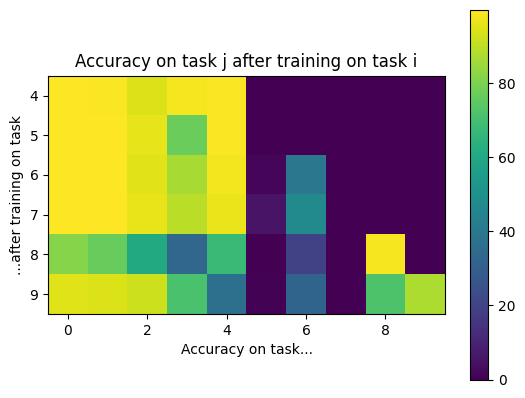

In [31]:
plt.imshow(test_accs_matrix, cmap='viridis', interpolation='nearest')
plt.yticks(np.arange(6), np.arange(4, 10))
plt.xlabel("Accuracy on task...")
plt.ylabel("...after training on task")
plt.title("Accuracy on task j after training on task i")
plt.colorbar()
plt.savefig("LoRA_greedy_HPO_matrix_ICL5.png")
plt.show()